# 1.IMPORT LIBRARIES

In [75]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller

# 2. READING AND PROCESSING DATA

In [76]:
# Read data from the CSV file
file_path = '/content/ETH-USD.csv'  # Change to the actual path of your CSV file
df = pd.read_csv(file_path)

df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
# Display the first few rows of the data
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-11,1268.089966,1337.300049,1135.170044,1154.930054,1154.930054,7235899904
1,2018-01-12,1158.290039,1296.040039,1120.089966,1273.199951,1273.199951,5222300160
2,2018-01-13,1270.469971,1432.880005,1270.469971,1396.420044,1396.420044,5746760192
3,2018-01-14,1397.479980,1400.560059,1286.209961,1366.770020,1366.770020,4841630208
4,2018-01-15,1365.209961,1390.589966,1290.599976,1291.920044,1291.920044,4781100032
...,...,...,...,...,...,...,...
1822,2023-01-07,1269.419800,1270.598267,1262.271118,1264.270386,1264.270386,2565213548
1823,2023-01-08,1264.181885,1287.359497,1260.226807,1287.359497,1287.359497,3495088905
1824,2023-01-09,1287.450806,1342.144165,1286.680786,1321.538940,1321.538940,7990438824
1825,2023-01-10,1321.395508,1342.757202,1318.527222,1336.586060,1336.586060,5830173253


# 3. CHART SHOW


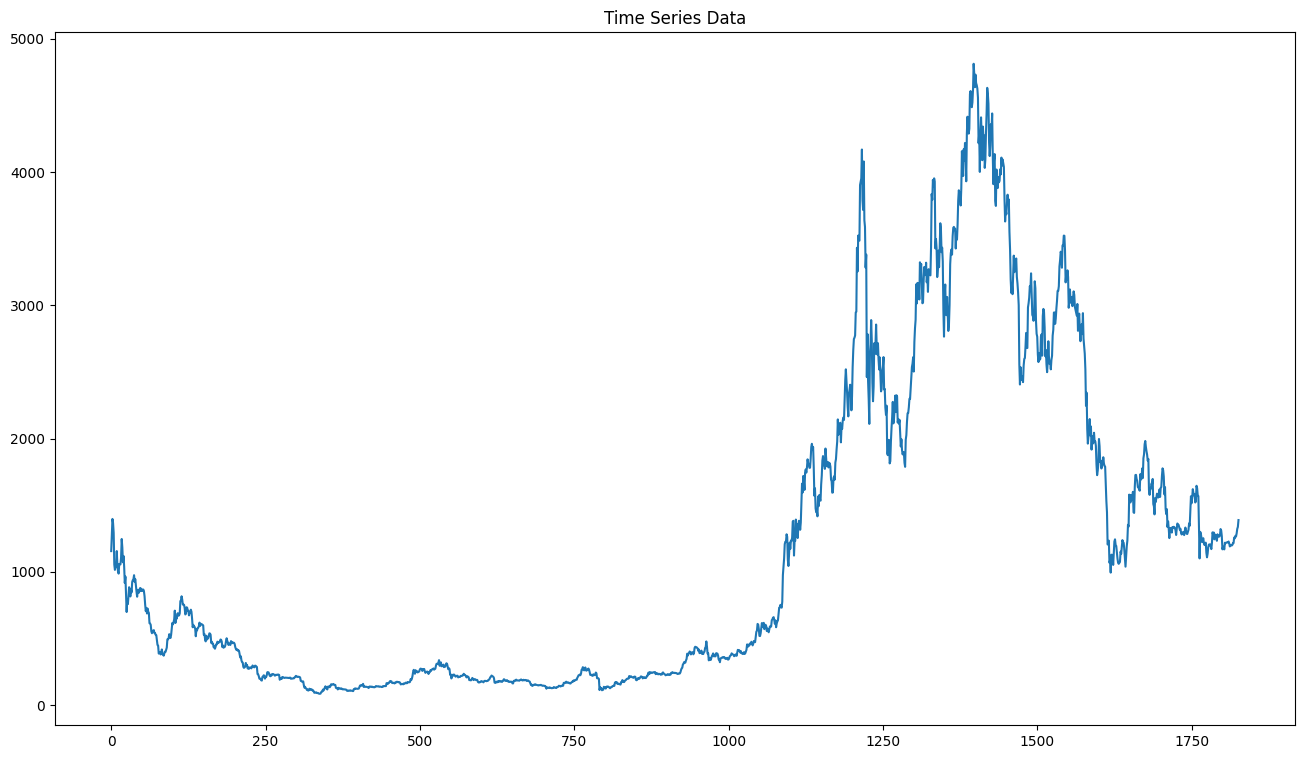

In [77]:
plt.figure(figsize=(16,9))
plt.title('Time Series Data')
plt.plot(df['Close'])
plt.show()

# 4. CHECK ADF TEST TO SEE IF THE DATA IS STATIONARY

In [78]:
# Function to test stationarity using ADF test
def adf_test(timeseries):
    timeseries.replace([np.inf, -np.inf], np.nan, inplace=True)
    timeseries.dropna(inplace=True)
    result = adfuller(timeseries, autolag='AIC')

    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

    # Check the p-value
    if result[1] <= 0.05:
        print("Reject the null hypothesis. Data is stationary.")
    else:
        print("Fail to reject the null hypothesis. Data is non-stationary.")

# Test the stationarity of the data
adf_test(df['Close'])

ADF Statistic: -1.3211394388208608
p-value: 0.6194463638679484
Critical Values: {'1%': -3.4339700129534423, '5%': -2.8631390341376393, '10%': -2.567621272963846}
Fail to reject the null hypothesis. Data is non-stationary.


# 5. THE RESULT SHOW THAT THE DATA IS NON-STATIONARY
 SO WE NEED TO USE METHOD TO MAKE IT STATIONARY - IN HERE IS DIFF METHOD

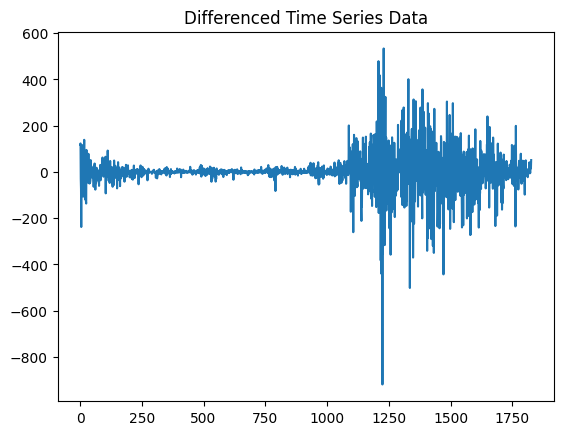

ADF Statistic: -10.631732566560162
p-value: 5.193470242471054e-19
Critical Values: {'1%': -3.4339700129534423, '5%': -2.8631390341376393, '10%': -2.567621272963846}
Reject the null hypothesis. Data is stationary.


In [79]:
# Take the first difference to make the data stationary
df['Close_diff'] = df['Close'].diff().dropna()

# Visualize the differenced data (if needed)
plt.plot(df['Close_diff'])
plt.title('Differenced Time Series Data')
plt.show()

# Test the stationarity of the differenced data
adf_test(df['Close_diff'])

# 6. NOW THE P-VALUE IS < 0.05 SO THE DATA IS STATIONARY
Next we will import auto_arima to find the best model


In [80]:
!pip install pmdarima


In [81]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

In [82]:
# Split the data into training, testing, and validation sets 6:2:2
train_size = int(0.6 * len(df))
test_size = int(0.2* len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]


x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

In [83]:
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=9976.250, Time=1.10 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=10631.265, Time=0.08 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=10340.576, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=9977.983, Time=0.19 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=9975.656, Time=0.59 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=9975.714, Time=0.54 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=9975.538, Time=0.43 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.51 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=10218.555, Time=0.17 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.91 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0]          
Total fit time: 5.638 seconds


ARIMA(order=(1, 2, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

# 7. THE BEST ARIMA MODEL IS (1,1,1)


In [84]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [85]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)


# Create an array of 100 consecutive integers starting from last_index
x_next_100_days = np.array(range(last_index+1, last_index+101)).reshape(-1, 1)

# Predict the closing prices for the next 100 days
y_next_100_days = model.predict(n_periods=len(x_next_100_days))

# Print the predicted closing prices for the next 100 days
print('Predicted closing prices for the next 100 days:')
print(y_next_100_days)

Predicted closing prices for the next 30 days:
[1268.47194759 1276.35409826 1284.34581797 1292.34478334 1300.34422785
 1308.34370405 1316.34318234 1324.34266077 1332.34213921 1340.34161765
 1348.34109609 1356.34057453 1364.34005297 1372.33953141 1380.33900985
 1388.33848829 1396.33796673 1404.33744517 1412.33692361 1420.33640205
 1428.33588049 1436.33535893 1444.33483737 1452.33431581 1460.33379425
 1468.33327269 1476.33275113 1484.33222958 1492.33170802 1500.33118646]
Predicted closing prices for the next 100 days:
[1268.47194759 1276.35409826 1284.34581797 1292.34478334 1300.34422785
 1308.34370405 1316.34318234 1324.34266077 1332.34213921 1340.34161765
 1348.34109609 1356.34057453 1364.34005297 1372.33953141 1380.33900985
 1388.33848829 1396.33796673 1404.33744517 1412.33692361 1420.33640205
 1428.33588049 1436.33535893 1444.33483737 1452.33431581 1460.33379425
 1468.33327269 1476.33275113 1484.33222958 1492.33170802 1500.33118646
 1508.3306649  1516.33014334 1524.32962178 1532.3291

# 8. ACCURACY ASSESSMENT

In [86]:
# 7. Đánh giá độ chính xác validate, test
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
valid_mae = np.mean(np.abs(y_pred_val - y_val))
valid_mape = np.mean(np.abs((y_pred_val - y_val) / y_val)) * 100

test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mae = np.mean(np.abs(y_pred - y_test))
test_mape = np.mean(np.abs((y_pred - y_test) / y_test)) * 100

print('Validation RMSE:', valid_rmse)
print('Validation MAE:', valid_mae)
print('Validation MAPE:', valid_mape)

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Testing MAPE:', test_mape)

Validation RMSE: 1717.9665761904935
Validation MAE: 1566.1274010649165
Validation MAPE: 101.86408212404785
Testing RMSE: 516.2940332909246
Testing MAE: 376.3434659100772
Testing MAPE: 13.21918540251211


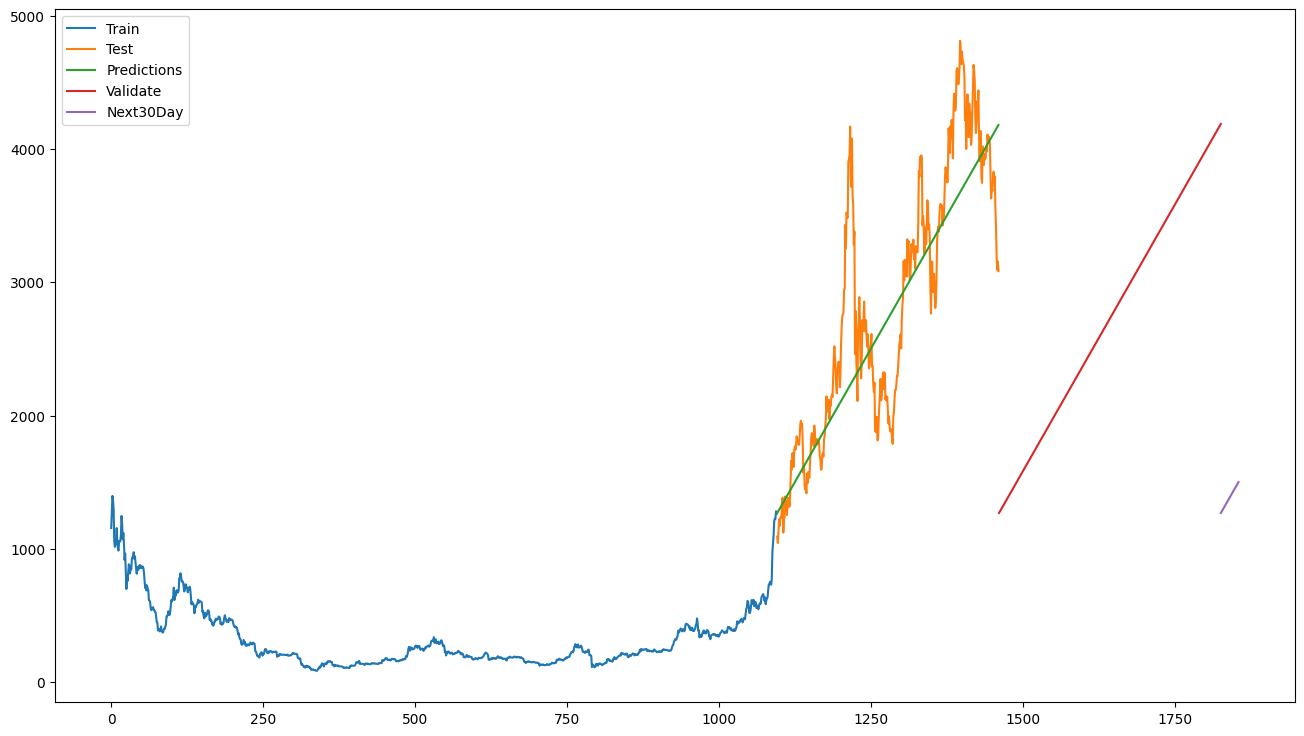

In [87]:

# 9.Vẽ hình
plt.figure(figsize=(16,9))
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()